# Hand sign classification

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
import torch
import timm
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

/home/tommaso/Applications/miniconda3/envs/hands/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### CONSTANTS

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

## prepare the dataset

In [3]:

# 1. Download dataset with kagglehub
path = kagglehub.dataset_download("jeyasrisenthil/hand-signs-asl-hand-sign-data")
print("Path to dataset files:", path)

# The dataset unpacks into something like: <path>/asl_dataset/<class>/*.jpg
# Let's point ImageFolder to the root that contains the class folders
data_root = os.path.join(path, "DATASET")  # adjust if you see an extra nested folder

# 2. Define transforms
full_dataset = datasets.ImageFolder(root=data_root, transform=transforms.ToTensor())
print("Total images:", len(full_dataset))
print("Classes:", full_dataset.classes)


Path to dataset files: /home/tommaso/.cache/kagglehub/datasets/jeyasrisenthil/hand-signs-asl-hand-sign-data/versions/1
Total images: 900
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
test_ratio = 0.2
test_size = int(len(full_dataset) * test_ratio)
train_size = len(full_dataset) - test_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

Train samples: 720
Test samples: 180


In [5]:
def compute_mean_std(dataset):
    # accumulate sum and sum of squares
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.0
    sq_mean = 0.0
    n_samples = 0
    for imgs, _ in loader:
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, imgs.size(1), -1)  # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        sq_mean += (imgs ** 2).mean(2).sum(0)
        n_samples += batch_samples
    mean /= n_samples
    sq_mean /= n_samples
    std = (sq_mean - mean ** 2).sqrt()
    return mean, std

mean, std = compute_mean_std(train_dataset)
print("Training set mean:", mean)
print("Training set std:", std)

Training set mean: tensor([0.8982, 0.8347, 0.8425])
Training set std: tensor([0.1553, 0.2467, 0.2402])


In [6]:
img_size = IMG_SIZE

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Update datasets with transforms
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

# -------- 5️⃣ Create DataLoaders --------
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/tmp/ipykernel_681618/189702565.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = img * torch.tensor(std).view(1,1,3) + torch.tensor(mean).view(1,1,3)


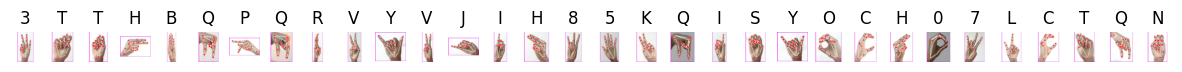

In [7]:
def show_batch(loader, classes):
    imgs, labels = next(iter(loader))
    imgs = imgs.permute(0,2,3,1)  # CHW -> HWC
    fig, axes = plt.subplots(1, len(imgs), figsize=(15,3))
    for ax, img, lbl in zip(axes, imgs, labels):
        # Undo normalization for visualization
        img = img * torch.tensor(std).view(1,1,3) + torch.tensor(mean).view(1,1,3)
        img = img.clamp(0,1).numpy()
        ax.imshow(img)
        ax.set_title(classes[lbl])
        ax.axis("off")
    plt.show()

show_batch(train_loader, full_dataset.classes)

## Load a pre-trained model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(full_dataset.classes)

model definition

In [9]:
model = timm.create_model('mobilenetv1_100', pretrained=True)
if hasattr(model, 'classifier'):
    in_feats = model.classifier.in_features
    model.classifier = nn.Linear(in_feats, num_classes)
elif hasattr(model, 'fc'):
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
else:
    model.head = nn.Linear(model.num_features, num_classes)

model = model.to(device)

model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1)

training

In [10]:
def calculate_accuracy(best_guesses, targets):
    num_correct = torch.eq(targets, best_guesses).sum().item()
    total_guesses = len(targets)
    correct_percentage = num_correct/total_guesses
    return correct_percentage


def validate(net, val_loader, loss_function):
    val_losses = []
    val_accuracy = []

    net.eval()
    with torch.no_grad():
        for batch_idx, data in tqdm(enumerate(val_loader), total=len(val_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = net(inputs)

            loss = loss_function(outputs, labels)
            val_losses.append(loss)
            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            val_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))

    average_val_loss = sum(val_losses) / (batch_idx+1)
    average_val_accuracy = sum(val_accuracy) / len(val_loader)
    return average_val_accuracy, average_val_loss


def training(net, train_loader, val_loader, loss_function, epochs, lr=3e-4):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    tot_train_batches = len(train_loader)

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for epoch in range(epochs):
        total_epoch_loss = 0
        train_accuracy = []

        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=tot_train_batches)
        net.train()
        for batch_idx, data in progress:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            net.zero_grad()
            loss.backward()
            optimizer.step()

            current_loss = loss.item()

            total_epoch_loss += current_loss
            average_train_loss = total_epoch_loss / (batch_idx + 1)

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction
            train_accuracy.append(calculate_accuracy(predicted_classes.cpu(), labels.cpu()))
            average_train_accuracy = sum(train_accuracy) / (batch_idx + 1)

            progress.set_description("Training Loss: {:.4f}, Accuracy: {:.4f}".format(average_train_loss, average_train_accuracy))

        average_val_accuracy, average_val_loss = validate(net, val_loader, loss_function)
        average_train_accuracy = sum(train_accuracy) / tot_train_batches

        print('Epoch %d/%d' % (epoch + 1,epochs), 'Training loss:  %.4f' % (average_train_loss), 'Accuracy: %.4f' % (average_train_accuracy))
        print('Validation Loss: %.4f' % (average_val_loss), 'Accuracy: %.4f' % (average_val_accuracy))

        train_loss_history.append(average_train_loss)
        val_loss_history.append(average_val_loss)
        train_accuracy_history.append(average_train_accuracy)
        val_accuracy_history.append(average_val_accuracy)

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history



In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = EPOCHS

t_loss, t_acc, val_loss, val_acc= training(model, train_loader, test_loader, criterion, epochs)

100%|██████████| 6/6 [00:00<00:00, 38.17it/s]

Epoch 1/10 Training loss:  2.5135 Accuracy: 0.4226
Validation Loss: 2.2846 Accuracy: 0.3125



100%|██████████| 6/6 [00:00<00:00, 40.06it/s]

Epoch 2/10 Training loss:  0.6308 Accuracy: 0.9049
Validation Loss: 0.7708 Accuracy: 0.7719



100%|██████████| 6/6 [00:00<00:00, 41.47it/s]

Epoch 3/10 Training loss:  0.1896 Accuracy: 0.9742
Validation Loss: 0.4576 Accuracy: 0.8573



100%|██████████| 6/6 [00:00<00:00, 40.11it/s]

Epoch 4/10 Training loss:  0.0948 Accuracy: 0.9837
Validation Loss: 1.0355 Accuracy: 0.7240



100%|██████████| 6/6 [00:00<00:00, 40.81it/s]

Epoch 5/10 Training loss:  0.0700 Accuracy: 0.9918
Validation Loss: 0.5897 Accuracy: 0.8292



100%|██████████| 6/6 [00:00<00:00, 38.56it/s]

Epoch 6/10 Training loss:  0.0636 Accuracy: 0.9891
Validation Loss: 0.2675 Accuracy: 0.9125



100%|██████████| 6/6 [00:00<00:00, 41.98it/s]

Epoch 7/10 Training loss:  0.0589 Accuracy: 0.9878
Validation Loss: 0.2675 Accuracy: 0.9271



100%|██████████| 6/6 [00:00<00:00, 40.90it/s]

Epoch 8/10 Training loss:  0.0434 Accuracy: 0.9891
Validation Loss: 0.4090 Accuracy: 0.8896



100%|██████████| 6/6 [00:00<00:00, 41.93it/s]

Epoch 9/10 Training loss:  0.0968 Accuracy: 0.9769
Validation Loss: 0.6870 Accuracy: 0.8104



100%|██████████| 6/6 [00:00<00:00, 40.38it/s]

Epoch 10/10 Training loss:  0.0595 Accuracy: 0.9837
Validation Loss: 0.7040 Accuracy: 0.7750


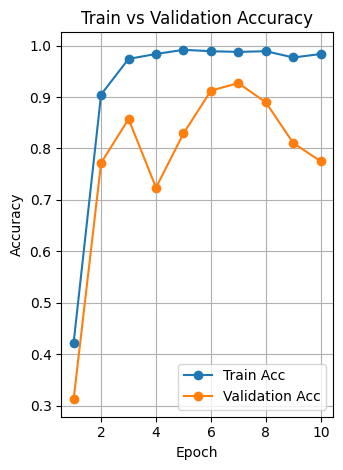

In [12]:
epochs_range = range(1, len(t_loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs_range, t_acc, label='Train Acc', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Acc', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ONNX export

In [15]:
dummy_input = torch.randn(1, 3, img_size, img_size, device=device)
model.eval()
os.makedirs("./models", exist_ok=True)
torch.onnx.export(model, dummy_input, "./models/asl_classification.onnx",
                  opset_version=11,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes=None)  # static shapes required for DPU
print("Exported ONNX model ready for Vitis AI quantization.")

/tmp/ipykernel_681618/2313090671.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy_input, "./models/asl_classification.onnx",


Exported ONNX model ready for Vitis AI quantization.
